In [3]:
!pip install torchsummary

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary
import warnings
import os
import sys
from tqdm import tqdm
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
RESOLUTION = 64

In [7]:
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

In [8]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    # transforms.Lambda(lambda x: x / 255.),
    transforms.Resize((RESOLUTION, RESOLUTION))
])


In [9]:
def plot_image_from_list(__images, __labels, __count):
    plt.figure(figsize=(10, 10))
    for _i in range(__count[0] * __count[1]):
        plt.subplot(__count[0], __count[1], _i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        _img = __images[_i].to("cpu").numpy()
        plt.imshow(_img, cmap= "gray")
        plt.xlabel(__labels[_i])
    plt.show()

In [10]:
def plot_randomly_form_dataset(__dataset):
    images = []
    labels = []
    for _ in range(0, 25):
        index = torch.randint(0, len(__dataset), (1,)).item()
        image, label = __dataset[index]
        images.append(image.squeeze())
        labels.append(__dataset.label_id2str(label.item()))
    
    plot_image_from_list(images, labels, (5, 5))
        

In [11]:
def plot_randomly_form_dataset_model(__dataset, __model):
    images = []
    labels = []
    for _ in range(0, 25):
        index = torch.randint(0, len(__dataset), (1,)).item()
        image, label = __dataset[index]
        images.append(image.squeeze())
        result = model(image.unsqueeze(dim=0).to(device)).squeeze().cpu().argmax()
        
        labels.append(__dataset.label_id2str(label.item()) + " -> " + __dataset.label_id2str(result.item()))
    
    plot_image_from_list(images, labels, (5, 5))
        

In [12]:
DATA_SOURCE = {
    "Robbery": "/kaggle/input/anomalydetectiondatasetucf/Anomaly-Videos-Part-3/Anomaly-Videos-Part-3/Robbery",
    "Shoplifting": "/kaggle/input/anomalydetectiondatasetucf/Anomaly-Videos-Part-4/Anomaly-Videos-Part-4/Shoplifting",
    "Stealing": "/kaggle/input/anomalydetectiondatasetucf/Anomaly-Videos-Part-4/Anomaly-Videos-Part-4/Stealing",
    "Burglary": "/kaggle/input/anomalydetectiondatasetucf/Anomaly-Videos-Part_2/Anomaly-Videos-Part-2/Burglary",
    "Normal_Videos": "/kaggle/input/anomalydetectiondatasetucf/Normal_Videos_for_Event_Recognition/Normal_Videos_for_Event_Recognition",
}

In [13]:
class CrimeDataset(Dataset):
    def __init__(self, __train=True, __tain_test_split=0.95, __random_state=42):
        torch.manual_seed(__random_state)
        
        self._data = []
        self._labels = []
        self._inclusion_probability = __tain_test_split if __train else 1.0 - __tain_test_split
        self._frame_interval = 30
        
        print(f"Loading {'train' if __train else 'test' } dataset...")
        for label, data_path in DATA_SOURCE.items():
            print(f"Loading Label {label}...")
            for file in tqdm(os.listdir(data_path)):
                if file.endswith(".mp4") and torch.rand(1).item() <= self._inclusion_probability:
                    path = os.path.join(data_path, file)
                    data, labels = self._parse_file(path, label)
                    self._data.extend(data)
                    self._labels.extend(labels)
        print(f"Finished loading {'train' if __train else 'test' } dataset... Loaded  {len(self._data)} images.")
    
    def _parse_file(self, __path, __label):
        if not os.path.exists(__path):
            return [], []
        
        data = []
        labels = []
        
        cap = cv2.VideoCapture(__path)
        
        success, image = cap.read()
        while success:
            try:
                if True:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
                    Y, U, V = cv2.split(image)
                    image = transformer(Y)
                    data.append(image)
                    labels.append(__label)
            except Exception as e:
                print(f"Error loading file {__path}: {e}")
            
            count = 0
            while success and count < self._frame_interval:
                success, image = cap.read()
                count += 1
        return data, labels
        
    
    def label_str2id(self, __label):
        labels = DATA_SOURCE.keys()
        return list(labels).index(__label)

    def label_id2str(self, __label):
        labels = DATA_SOURCE.keys()
        return list(labels)[__label]
        
    def __len__(self):
        return len(self._labels)

    def __getitem__(self, __idx):
        data = self._data[__idx]
        label = self._labels[__idx]
        return data, torch.tensor([self.label_str2id(label)])

In [14]:
train_dataset = CrimeDataset(True)
test_dataset = CrimeDataset(False)

Loading train dataset...
Loading Label Robbery...


  0%|          | 0/150 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 150/150 [02:19<00:00,  1.08it/s]


Loading Label Shoplifting...


100%|██████████| 50/50 [01:57<00:00,  2.34s/it]


Loading Label Stealing...


100%|██████████| 100/100 [02:32<00:00,  1.52s/it]


Loading Label Burglary...


100%|██████████| 100/100 [02:21<00:00,  1.42s/it]


Loading Label Normal_Videos...


100%|██████████| 50/50 [00:48<00:00,  1.02it/s]


Finished loading train dataset... Loaded  59348 images.
Loading test dataset...
Loading Label Robbery...


100%|██████████| 150/150 [00:03<00:00, 39.15it/s]


Loading Label Shoplifting...


100%|██████████| 50/50 [00:00<00:00, 63.13it/s]


Loading Label Stealing...


100%|██████████| 100/100 [00:13<00:00,  7.33it/s]


Loading Label Burglary...


100%|██████████| 100/100 [00:02<00:00, 34.06it/s]


Loading Label Normal_Videos...


100%|██████████| 50/50 [00:02<00:00, 19.76it/s]

Finished loading test dataset... Loaded  2371 images.


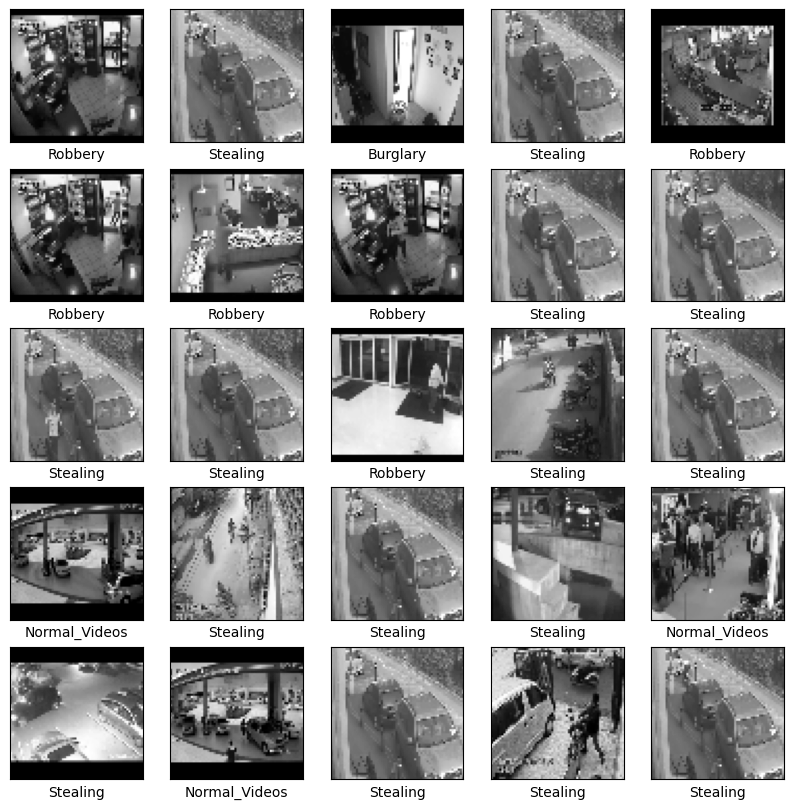

In [15]:
plot_randomly_form_dataset(test_dataset)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=True)

In [17]:
class CrimeModelCNN(nn.Module):
    def __init__(self):
        super(CrimeModelCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding="same")
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.max_pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding="same")
        self.max_pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding="same")
        self.max_pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.4)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16384, 256)
        self.dropout4 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.max_pool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.max_pool2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.leaky_relu(x)
        x = self.max_pool3(x)
        x = self.dropout3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.dropout4(x)
        return x

In [18]:
class CrimeModelLSTM(nn.Module):
    def __init__(self):
        super(CrimeModelLSTM, self).__init__()
        self.lstm1 = nn.LSTM(1, 8, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(8, 8, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(8, 4)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        x = self.fc(x)
        x = self.dropout(x)
        return x

In [19]:

class CrimeModel(nn.Module):
    def __init__(self):
        super(CrimeModel, self).__init__()
        self.cnn = CrimeModelCNN()
        self.lstm = CrimeModelLSTM()
        self.fc = nn.Linear(260, 7)  # Adjust the input size according to your concatenation axis

    def forward(self, x):
        x_cnn = x
        x_lstm = torch.reshape(x, (x.shape[0], RESOLUTION * RESOLUTION, 1))
        x_cnn = self.cnn(x_cnn)
        x_lstm = self.lstm(x_lstm)
        x_combined = torch.cat((x_cnn, x_lstm), dim=1)
        x = self.fc(x_combined)
#         return F.softmax(x, dim=1)
        return x

In [20]:
model = CrimeModel()

In [21]:
print(model(torch.rand(64, 1, 64, 64)).shape)

torch.Size([64, 7])


In [22]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [23]:
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): CrimeModel(
    (cnn): CrimeModelCNN(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (leaky_relu): LeakyReLU(negative_slope=0.1)
      (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout1): Dropout(p=0.25, inplace=False)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout2): Dropout(p=0.25, inplace=False)
      (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout3): Dropout(p=0.4, inplace=False)
      (flatten): Flatten(start_dim=1, end_dim=-1)
      (fc1): Linear(in_features=16384, out_features=256, bias=True)
      (dropout4): Dropout(p=0.5, inplace=False)
    )
    (lstm): CrimeModelLSTM(
      (lstm1): LSTM

In [24]:
NUM_EPOCHS = 10

In [25]:
for epoch in range(NUM_EPOCHS):
    model.train()
    _total_correct = 0
    _total_samples = 0
    
    print(f"Epoch : {epoch + 1}...")
    
    for batch_idx, (data, label) in enumerate(train_loader):
        print(f"Batch : {batch_idx + 1}/{len(train_loader)}\t\t", end="\r")
        
        data = data.to(device)
        label = label.to(device)
        
        preds = model(data)
        
        loss = criterion(preds, label.squeeze())
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        # Calculate training accuracy
        _, predicted = torch.max(preds, 1)
        _total_correct += (predicted == label.squeeze()).sum().item()
        _total_samples += label.size(0)
        
        if batch_idx % 10 == 0:
            print(f"Loss: {loss.item()}, Batch: {batch_idx + 1}/{len(train_loader)}")

    train_accuracy = 100.0 * _total_correct / _total_samples
    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Training Accuracy: {train_accuracy:.2f}%")


Epoch : 1...
Loss: 1.9864017963409424, Batch: 1/116
Loss: 44.508487701416016, Batch: 11/116
Loss: 10.979612350463867, Batch: 21/116
Loss: 5.116893768310547, Batch: 31/116
Loss: 2.679006338119507, Batch: 41/116
Loss: 2.03120756149292, Batch: 51/116
Loss: 1.51738703250885, Batch: 61/116
Loss: 1.363463044166565, Batch: 71/116
Loss: 1.277025580406189, Batch: 81/116
Loss: 1.3340381383895874, Batch: 91/116
Loss: 1.2373769283294678, Batch: 101/116
Loss: 1.1772596836090088, Batch: 111/116
Epoch [1/10], Training Accuracy: 37.28%
Epoch : 2...
Loss: 1.0589712858200073, Batch: 1/116
Loss: 1.0559874773025513, Batch: 11/116
Loss: 1.0241588354110718, Batch: 21/116
Loss: 1.0151845216751099, Batch: 31/116
Loss: 0.9290404319763184, Batch: 41/116
Loss: 0.8297508955001831, Batch: 51/116
Loss: 0.8787550926208496, Batch: 61/116
Loss: 0.6469289660453796, Batch: 71/116
Loss: 0.7816542983055115, Batch: 81/116
Loss: 0.6387017965316772, Batch: 91/116
Loss: 0.7065005302429199, Batch: 101/116
Loss: 0.5057129263877

In [26]:
# Evaluate the model on the test dataset and plot the confusion matrix
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for data, label in test_loader:
        data = data.to(device)
        label = label.to(device)
        
        preds = model(data)
        _, predicted = torch.max(preds, 1)
        
        y_true.extend(label.squeeze().cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 99.54%


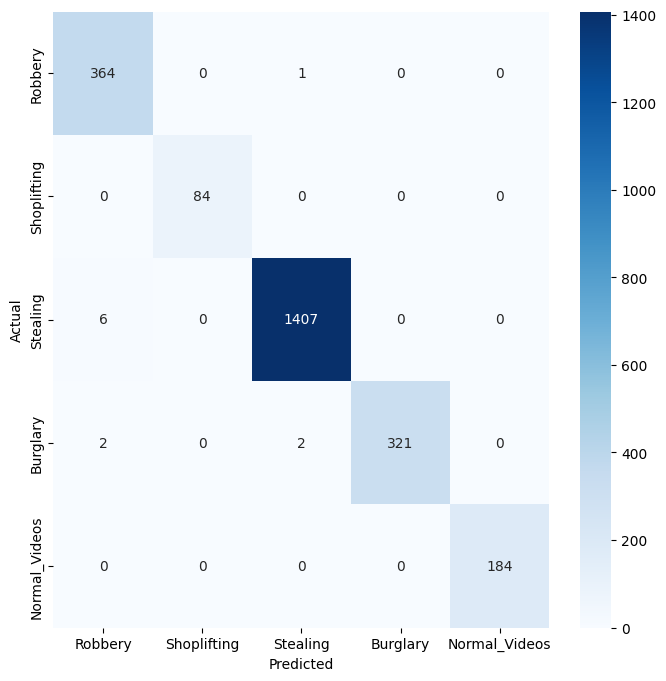

In [27]:
# Compute confusion matrix
class_names = list(DATA_SOURCE.keys())
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [28]:
# Save the trained model
torch.save(model, "model.pt")

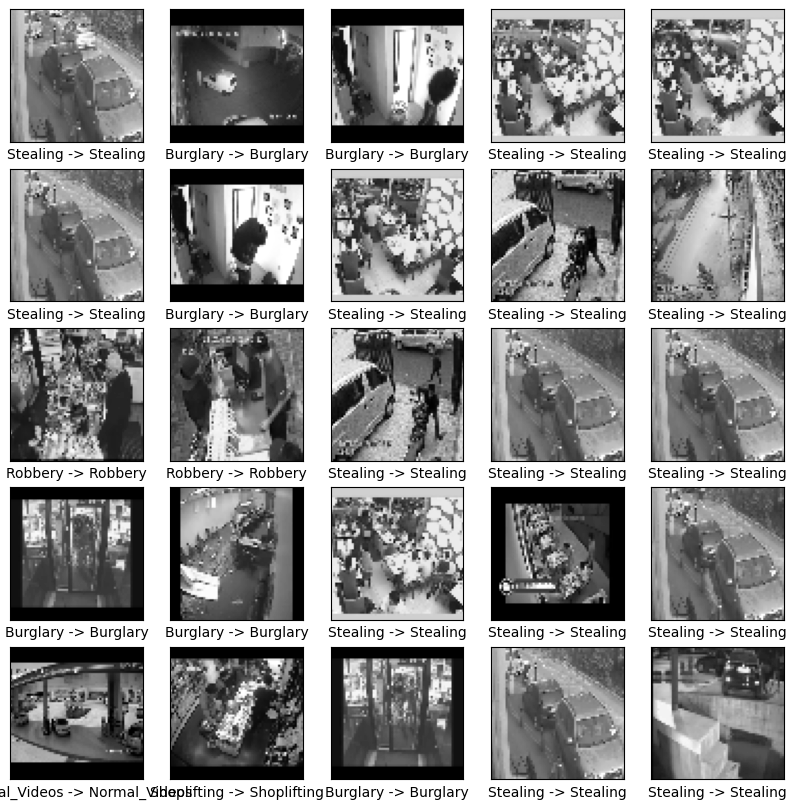

In [29]:
# Plotting randomly from the test dataset with model predictions
plot_randomly_form_dataset_model(test_dataset, model)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


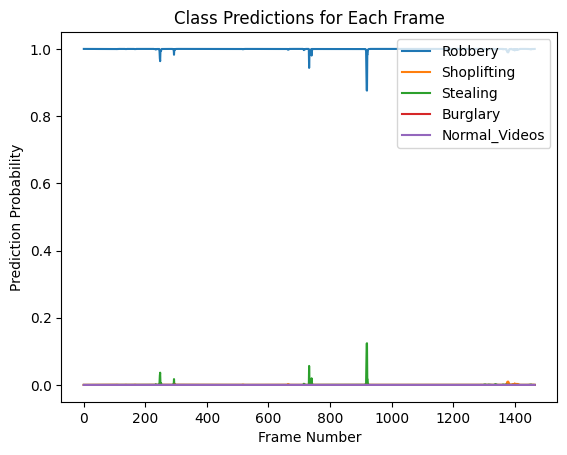

In [30]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary

# Define your transformation pipeline
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.Resize((RESOLUTION, RESOLUTION))
])

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load("model.pt")
model.eval()

# Define a function to process the video frame by frame
def predict_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    class_names = list(DATA_SOURCE.keys())
    frame_predictions = []

    with torch.no_grad():
        for _ in range(frame_count):
            success, frame = cap.read()
            if not success:
                break
            
            # Preprocess the frame
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2YUV)
            Y, U, V = cv2.split(frame)
            frame = transformer(Y).unsqueeze(0).to(device)
            
            # Get model predictions
            preds = model(frame)
            preds = torch.softmax(preds, dim=1).cpu().numpy().squeeze()
            
            frame_predictions.append(preds)
    
    cap.release()
    return np.array(frame_predictions), class_names

# Plot the predictions
def plot_predictions(predictions, class_names):
    for i, class_name in enumerate(class_names):
        plt.plot(predictions[:, i], label=class_name)
    
    plt.xlabel('Frame Number')
    plt.ylabel('Prediction Probability')
    plt.legend(loc='upper right')
    plt.title('Class Predictions for Each Frame')
    plt.show()

# Upload your video and get predictions
video_path = "/kaggle/input/anomalydetectiondatasetucf/Anomaly-Videos-Part-3/Anomaly-Videos-Part-3/Robbery/Robbery025_x264.mp4"  # Replace with the path to your video
predictions, class_names = predict_video(video_path)

# Plot the frame-by-frame predictions
plot_predictions(predictions, class_names)


In [34]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 79.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 94.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.4/121.4 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.18
    Uninstalling urllib3-1.26.18:
      Successfully uninstalled urllib3-1.26.18
  Attempting uninstall: tomlkit
    Found existing installation: tomlkit 0.12.5
    Uninstalling tomlkit-0.12.5:
      Successfully uninstalled tomlkit-0.12.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
distributed 2024.5.1 requires dask==2024.5.1, but you have dask 2024.7.0 which is inco

In [35]:
import gradio as gr
import torch
import cv2
import numpy as np
import tempfile
import torchvision.transforms as transforms

# Set the resolution
RESOLUTION = 64

# Define your transformation pipeline
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.Resize((RESOLUTION, RESOLUTION))
])

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load("model.pt")
model.eval()

# Define a function to process the video frame by frame
def predict_frame(frame):
    # Preprocess the frame
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2YUV)
    Y, U, V = cv2.split(frame)
    frame = transformer(Y).unsqueeze(0).to(device)

    # Get model predictions
    with torch.no_grad():
        preds = model(frame)
        preds = torch.softmax(preds, dim=1).cpu().numpy().squeeze()

    return preds

# Define a function to annotate video with class predictions
def annotate_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Create temporary file to save annotated video
    output_file = tempfile.NamedTemporaryFile(delete=False, suffix='.mp4')
    output_path = output_file.name

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    class_names = list(DATA_SOURCE.keys())
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    for _ in range(frame_count):
        success, frame = cap.read()
        if not success:
            break

        # Predict the class of the current frame
        preds = predict_frame(frame)
        predicted_class = class_names[np.argmax(preds)]
        confidence = np.max(preds)

        # Annotate the frame
        text = f"{predicted_class} ({confidence:.2f})"
        cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        
        # Write the annotated frame to the output video
        out.write(frame)

    cap.release()
    out.release()

    return output_path

# Gradio App
def process_video(video):
    output_video_path = annotate_video(video)
    return output_video_path

# Create Gradio interface
iface = gr.Interface(
    fn=process_video,
    inputs=gr.Video(type="file"),
    outputs=gr.Video(),
    title="Crime Detection in Video",
    description="Upload a video to see frame-by-frame crime detection predictions.",
)

# Launch the Gradio app
iface.launch()

TypeError: Video.__init__() got an unexpected keyword argument 'type'

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define dataset paths
DATA_SOURCE = {
    "Robbery": "/kaggle/input/anomalydetectiondatasetucf/Anomaly-Videos-Part-3/Anomaly-Videos-Part-3/Robbery",
    "Shoplifting": "/kaggle/input/anomalydetectiondatasetucf/Anomaly-Videos-Part-4/Anomaly-Videos-Part-4/Shoplifting",
    "Stealing": "/kaggle/input/anomalydetectiondatasetucf/Anomaly-Videos-Part-4/Anomaly-Videos-Part-4/Stealing",
    "Burglary": "/kaggle/input/anomalydetectiondatasetucf/Anomaly-Videos-Part_2/Anomaly-Videos-Part-2/Burglary",
    "Normal_Videos": "/kaggle/input/anomalydetectiondatasetucf/Normal_Videos_for_Event_Recognition/Normal_Videos_for_Event_Recognition",
}

# Preprocessing transformations
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.Resize((64, 64))
])

class CrimeDataset(Dataset):
    def __init__(self, train=True, train_test_split=0.95, random_state=42, sequence_length=16):
        torch.manual_seed(random_state)
        self.data = []
        self.labels = []
        self.sequence_length = sequence_length
        self.inclusion_probability = train_test_split if train else 1.0 - train_test_split

        print(f"Loading {'train' if train else 'test'} dataset...")
        for label, data_path in DATA_SOURCE.items():
            print(f"Loading Label {label}...")
            for file in tqdm(os.listdir(data_path)):
                if file.endswith(".mp4") and torch.rand(1).item() <= self.inclusion_probability:
                    path = os.path.join(data_path, file)
                    data, labels = self._parse_file(path, label)
                    self.data.extend(data)
                    self.labels.extend(labels)
        print(f"Finished loading {'train' if train else 'test'} dataset... Loaded {len(self.data)} sequences.")

    def _parse_file(self, path, label):
        if not os.path.exists(path):
            return [], []

        data = []
        labels = []

        cap = cv2.VideoCapture(path)
        frames = []

        while len(frames) < self.sequence_length:
            success, image = cap.read()
            if not success:
                break
            image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            Y, _, _ = cv2.split(image)
            Y = transformer(Y)
            frames.append(Y)

        if len(frames) == self.sequence_length:
            data.append(torch.stack(frames, dim=1))
            labels.append(self.label_str2id(label))

        return data, labels

    def label_str2id(self, label):
        labels = list(DATA_SOURCE.keys())
        return labels.index(label)

    def label_id2str(self, label_id):
        labels = list(DATA_SOURCE.keys())
        return labels[label_id]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx]
        return data, torch.tensor([label])

train_dataset = CrimeDataset(train=True)
test_dataset = CrimeDataset(train=False)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

class VideoModel3DCNN_LSTM(nn.Module):
    def __init__(self, num_classes=5):
        super(VideoModel3DCNN_LSTM, self).__init__()
        
        # 3D CNN for Spatio-Temporal Feature Extraction
        self.conv3d_1 = nn.Conv3d(in_channels=1, out_channels=64, kernel_size=(3, 3, 3), stride=1, padding=1)
        self.conv3d_2 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(3, 3, 3), stride=1, padding=1)
        self.conv3d_3 = nn.Conv3d(in_channels=128, out_channels=256, kernel_size=(3, 3, 3), stride=1, padding=1)
        
        self.pool3d = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.dropout3d = nn.Dropout(0.3)
        
        # LSTM for Temporal Modeling
        self.lstm = nn.LSTM(input_size=256*8*8, hidden_size=512, num_layers=2, batch_first=True, bidirectional=True)
        self.dropout_lstm = nn.Dropout(0.5)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(512*2, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        # 3D CNN
        x = self.conv3d_1(x)
        x = F.relu(x)
        x = self.pool3d(x)
        x = self.dropout3d(x)
        
        x = self.conv3d_2(x)
        x = F.relu(x)
        x = self.pool3d(x)
        x = self.dropout3d(x)
        
        x = self.conv3d_3(x)
        x = F.relu(x)
        x = self.pool3d(x)
        x = self.dropout3d(x)
        
        # Flattening and LSTM
        x = torch.flatten(x, start_dim=2)
        x = x.permute(0, 2, 1)  # (batch_size, seq_len, feature_dim)
        x, _ = self.lstm(x)
        x = self.dropout_lstm(x[:, -1, :])  # Take the last output from LSTM
        
        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

model = VideoModel3DCNN_LSTM(num_classes=len(DATA_SOURCE)).to(device)

# Model summary
from torchsummary import summary
summary(model, input_size=(1, 16, 64, 64))

# Training setup
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    model.train()
    total_correct = 0
    total_loss = 0
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device).squeeze()
        
        optimizer.zero_grad()
        preds = model(data)
        
        loss = criterion(preds, label)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_correct += (preds.argmax(1) == label).sum().item()
        
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")
    
    accuracy = total_correct / len(train_dataset)
    print(f"Training accuracy: {accuracy:.4f}, Loss: {total_loss / len(train_loader):.4f}")
    
    # Save model checkpoint
    torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")

# Evaluate model on test data
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for data, label in test_loader:
        data = data.to(device)
        label = label.to(device).squeeze()
        
        preds = model(data)
        test_preds.extend(preds.argmax(1).cpu().numpy())
        test_labels.extend(label.cpu().numpy())

# Compute accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot confusion matrix
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=DATA_SOURCE.keys(), yticklabels=DATA_SOURCE.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()